In [1]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(42)
random.seed(42)


In [2]:

# reload when updating code
importlib.reload(preprocess)
# mouse and date

mice = ['NN11'] 
dates_per_mouse = {'NN11': ['210626']}

for mouse in mice:
    dates = dates_per_mouse[mouse]  # Get the list of dates for the current mouse
    days = len(dates)  # Correct number of days for this mouse
    
    for day_idx, date in enumerate(dates):
        print(mouse, date)
        
        # Create folders to save files
        paths = preprocess.create_folders(mouse, date)
        print('folders created')
        
        # Import data for mouse and date as dict
        session_data = preprocess.load_data(paths)
        print('data loaded')
        
        # Process and plot behavior
        behavior = preprocess.process_behavior(session_data, paths)
        print('behavior done')
        
        # Save masks so can run in Matlab to process other planes
        # preprocess.cell_masks(paths, 0)
        print('masks saved')
        
        # Grab activity
        deconvolved = preprocess.process_activity(paths, 'spks', 3, 0)
        print('activity processed')
        
        # Normalize activity
        norm_deconvolved = preprocess.normalize_deconvolved(deconvolved, behavior, paths, 0)
        print('activity normalized')
        
        # Gaussian filter activity
        norm_moving_deconvolved_filtered = preprocess.difference_gaussian_filter(norm_deconvolved, 4, behavior, paths, 0)
        print('activity filtered')
        
        # Make trial-averaged traces and baseline subtract
        mean_cs_1_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_1')
        mean_cs_2_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_2')
        print('traces done')
        
        # Get significant cells
        [cs_1_poscells, cs_1_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_1')
        [cs_2_poscells, cs_2_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_2')
        [both_poscells, both_sigcells] = preprocess.combine_sig(cs_1_poscells, cs_1_negcells, cs_2_poscells, cs_2_negcells)
        print('sig cells done')
        
        # Get index of top cell differences
        idx = preprocess.get_index(behavior, mean_cs_1_responses_df, mean_cs_2_responses_df, cs_1_poscells, cs_2_poscells, both_poscells, both_sigcells, paths, 1)
        print('idx done')
        
        # Get prior for synchronous cue activity
        prior = classify.prior(norm_moving_deconvolved_filtered, idx['cs_1'], idx['cs_2'], behavior, [])
        print('prior done')
        
        # Logistic regression
        y_pred_log = classify.log_regression(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)
        print('logistic regression done')
        
        # Process classified output
        y_pred = classify.process_classified(y_pred_log, prior, paths, 1)
        print('classified done')
    


NN11 210626
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


In [15]:
activity = norm_deconvolved.to_numpy()
activity = activity[idx['both'].index]

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
topn = 0.05

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

# Normalize the mean activities for each trial.
mean_activity_cs_1 = mean_activity_cs_1 / np.mean(mean_activity_cs_any, axis=0)
mean_activity_cs_2 = mean_activity_cs_2 / np.mean(mean_activity_cs_any, axis=0)

mean_activity_cs_1 = np.stack(mean_activity_cs_1, axis=0)
mean_activity_cs_2 = np.stack(mean_activity_cs_2, axis=0)

# Calculate the mean of the first and last three mean activities for cs_1 and cs_2.
n_centroids = 3
mean_activity_cs_1_mean = [np.mean(mean_activity_cs_1[0:n_centroids], axis=0), np.mean(mean_activity_cs_1[len(mean_activity_cs_1) - n_centroids:len(mean_activity_cs_1)], axis=0)]
mean_activity_cs_2_mean = [np.mean(mean_activity_cs_2[0:n_centroids], axis=0), np.mean(mean_activity_cs_2[len(mean_activity_cs_2) - n_centroids:len(mean_activity_cs_2)], axis=0)]

# Calculate the difference vectors between the early and late mean activities for cs_1 and cs_2.
mean_activity_cs_1_vec = mean_activity_cs_1_mean[1] - mean_activity_cs_1_mean[0]
mean_activity_cs_2_vec = mean_activity_cs_2_mean[1] - mean_activity_cs_2_mean[0]

late_trails_1 = mean_activity_cs_1_mean[1]
top_n_percent_indices_1 = np.argsort(late_trails_1)[-int(len(late_trails_1) * topn):]
mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_percent_indices_1]
mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

late_trails_2 = mean_activity_cs_2_mean[1]
top_n_percent_indices_2 = np.argsort(late_trails_2)[-int(len(late_trails_2) * topn):]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_percent_indices_2]
mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_cs_1 = np.zeros(len(mean_activity_cs_1))
sim_cs_2 = np.zeros(len(mean_activity_cs_2))

# Normalize the mean activities for each trial using the difference vectors.
for i in range(0, len(mean_activity_cs_1)):
    sim_cs_1[i] = cos_sim(mean_activity_cstopn_1[i], mean_activity_cstopn_1_late)
    # sim_cs_1[i] = cos_sim(mean_activity_cs_1[i], mean_activity_cs_1_mean[1])
    # sim_cs_1[i] = np.dot(mean_activity_cs_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_cs_2)):
    sim_cs_2[i] = cos_sim(mean_activity_cstopn_2[i], mean_activity_cstopn_2_late)
    # sim_cs_2[i] = cos_sim(mean_activity_cs_2[i], mean_activity_cs_2_mean[1])
    # sim_cs_2[i] = np.dot(mean_activity_cs_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


# Initialize lists to store mean activities and trial indices for reactivation events.
mean_activity_r_1 = []
mean_activity_r_2 = []
mean_activity_r_any = []
trial_r_1 = []
trial_r_2 = []

# Copy reactivation predictions for cs_1 and cs_2.
reactivation_cs_1 = y_pred[:, 0].copy()
reactivation_cs_2 = y_pred[:, 1].copy()

# Set a threshold for reactivation probability.
p_threshold = .75

# Initialize variables for reactivation event detection.
cs_1_peak = 0
cs_2_peak = 0
i = 0
next_r = 0

# Loop through reactivation predictions to detect reactivation events.
while i < len(reactivation_cs_1) - 1:
    # Check if there is a reactivation event.
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        # Update peak reactivation values.
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
        #print(reactivation_cs_1[i + 1], reactivation_cs_2[i + 1])
        # Check if the reactivation event has ended.
        if reactivation_cs_1[i + 1] <= 0.001 and reactivation_cs_2[i + 1]<= 0.001:
            r_end = i + 1
            next_r = 0
            # Store mean activity and trial index for cs_1 reactivation events above the threshold.
            if cs_1_peak > p_threshold:
                for j in range(0, len(onsets_cs_1)):
                    if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and r_start < onsets_cs_1[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_1.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_1.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Store mean activity and trial index for cs_2 reactivation events above the threshold.
            if cs_2_peak > p_threshold:
                for j in range(0, len(onsets_cs_2)):
                    if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and r_start < onsets_cs_2[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_2.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_2.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Reset variables for the next reactivation event.
            i = r_end
            cs_1_peak = 0
            cs_2_peak = 0
    i += 1


# Normalize the reactivation mean activities.
mean_activity_r_1 = mean_activity_r_1 / np.mean(mean_activity_r_any, axis=0)
mean_activity_r_2 = mean_activity_r_2 / np.mean(mean_activity_r_any, axis=0)

mean_activity_r_1 = np.stack(mean_activity_r_1, axis=0)
mean_activity_r_2 = np.stack(mean_activity_r_2, axis=0)

# mean_activity_rtopn_1 = mean_activity_r_1[:, top_n_percent_indices_1]
# mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

# mean_activity_rtopn_2 = mean_activity_r_2[:, top_n_percent_indices_2]
# mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_r_1 = np.zeros(len(mean_activity_r_1))
sim_r_2 = np.zeros(len(mean_activity_r_2))

sim_r_1_random = np.zeros(len(mean_activity_r_1))

zero_indices = np.where(mean_activity_r_1 != 0)
    
# Normalize the reactivation mean activities using the difference vectors.
for i in range(0, len(mean_activity_r_1)):
    # nonzero_indices = np.where(mean_activity_r_1[i] != 0)
    top_n_percent_indices_r_1 = np.argsort(mean_activity_r_1[i])[-int(len(mean_activity_r_1[i]) * topn):]
    sim_r_1[i] = cos_sim(mean_activity_r_1[i][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)], mean_activity_cs_1_mean[1][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)])
    
    chosen_indices = np.random.randint(0, len(mean_activity_r_1[i]), 27)
    sim_r_1_random[i] = cos_sim(mean_activity_r_1[i][chosen_indices], mean_activity_cs_1_mean[1][chosen_indices])
    # sim_r_1[i] = cos_sim(mean_activity_rtopn_1[i], mean_activity_cstopn_1_late)
    # sim_r_1[i] = cos_sim(mean_activity_r_1[i], mean_activity_cs_1_mean[1])
    # sim_r_1[i] = np.dot(mean_activity_r_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_r_2)):
    # nonzero_indices = np.where(mean_activity_r_2[i] != 0)
    top_n_percent_indices_r_2 = np.argsort(mean_activity_r_2[i])[-int(len(mean_activity_r_2[i]) * topn):]
    sim_r_2[i] = cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], mean_activity_cs_2_mean[1][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)])
    # sim_r_2[i] = cos_sim(mean_activity_rtopn_2[i], mean_activity_cstopn_2_late)
    # sim_r_2[i] = cos_sim(mean_activity_r_2[i], mean_activity_cs_2_mean[1])
    # sim_r_2[i] = np.dot(mean_activity_r_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)



In [16]:
def compute_drift_per_trial(activity_matrix):
    """
    Compute drift (current trial - previous trial) for each neuron.
    :param activity_matrix: Trials x Neurons matrix of activity
    :return: Drift matrix (Trials-1 x Neurons)
    """
    return activity_matrix[1:, :] - activity_matrix[:-1, :]

drift_cs_1 = compute_drift_per_trial(mean_activity_cs_1)  # Shape: (trials-1, neurons)
drift_cs_2 = compute_drift_per_trial(mean_activity_cs_2)  # Shape: (trials-1, neurons)


In [22]:
from scipy.stats import t

drift_r_1 = drift_cs_1[trial_r_1]  # Reactivation drift values for stimulus 1
drift_r_2 = drift_cs_2[trial_r_2]

# Step 3: Compute correlations for each neuron
# Compute correlations between r1 activity and drift_cs_1
correlations_r1 = [
    np.corrcoef(mean_activity_r_1[:, neuron], drift_r_1[:, neuron])[0, 1]
    for neuron in range(mean_activity_r_1.shape[1])
]

# Compute correlations between r2 activity and cs_2
correlations_r2 = [
    np.corrcoef(mean_activity_r_2[:, neuron], drift_r_2[:, neuron])[0, 1]
    for neuron in range(mean_activity_r_2.shape[1])
]

def correlation_p_value(r, n):
    """Compute the p-value for a given correlation coefficient."""
    t_stat = r * np.sqrt((n - 2) / (1 - r**2))
    p_value = 2 * t.sf(np.abs(t_stat), df=n - 2)  # Two-tailed test
    return p_value

# Step 1: Compute p-values for r1
num_trials = mean_activity_r_1.shape[0]
p_values_r1 = [correlation_p_value(r, num_trials) for r in correlations_r1]

# Step 2: Compute p-values for r2
num_trials_r2 = mean_activity_r_2.shape[0]
p_values_r2 = [correlation_p_value(r, num_trials_r2) for r in correlations_r2]

# Step 3: Identify significant neurons
significant_neurons_r1 = [neuron for neuron, p in enumerate(p_values_r1) if p < 0.05]
significant_neurons_r2 = [neuron for neuron, p in enumerate(p_values_r2) if p < 0.05]

# Step 4: Print significant neurons
print(f"Significant neurons from r1: {len(significant_neurons_r1)} out of {len(correlations_r1)}")
print(f"Significant neurons from r2: {len(significant_neurons_r2)} out of {len(correlations_r2)}")




Significant neurons from r1: 247 out of 3124
Significant neurons from r2: 188 out of 3124


Epoch 1/50
6/6 [==============================] - 1s 32ms/step - loss: 0.4661 - mae: 0.5076 - val_loss: 0.4426 - val_mae: 0.4869
Epoch 2/50
6/6 [==============================] - 0s 16ms/step - loss: 0.4342 - mae: 0.4851 - val_loss: 0.4421 - val_mae: 0.4865
Epoch 3/50
6/6 [==============================] - 0s 16ms/step - loss: 0.4288 - mae: 0.4811 - val_loss: 0.4412 - val_mae: 0.4858
Epoch 4/50
6/6 [==============================] - 0s 16ms/step - loss: 0.4282 - mae: 0.4806 - val_loss: 0.4414 - val_mae: 0.4859
Epoch 5/50
6/6 [==============================] - 0s 17ms/step - loss: 0.4280 - mae: 0.4805 - val_loss: 0.4416 - val_mae: 0.4860
Epoch 6/50
6/6 [==============================] - 0s 16ms/step - loss: 0.4279 - mae: 0.4804 - val_loss: 0.4418 - val_mae: 0.4861
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.4277 - mae: 0.4803 - val_loss: 0.4419 - val_mae: 0.4861
Epoch 8/50
6/6 [==============================] - 0s 16ms/step - loss: 0.4276 - mae: 0.4802 - val

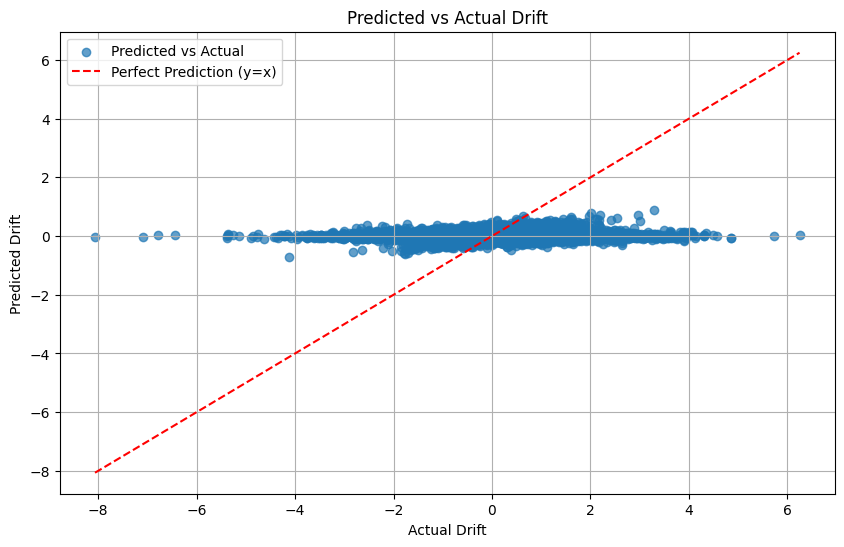

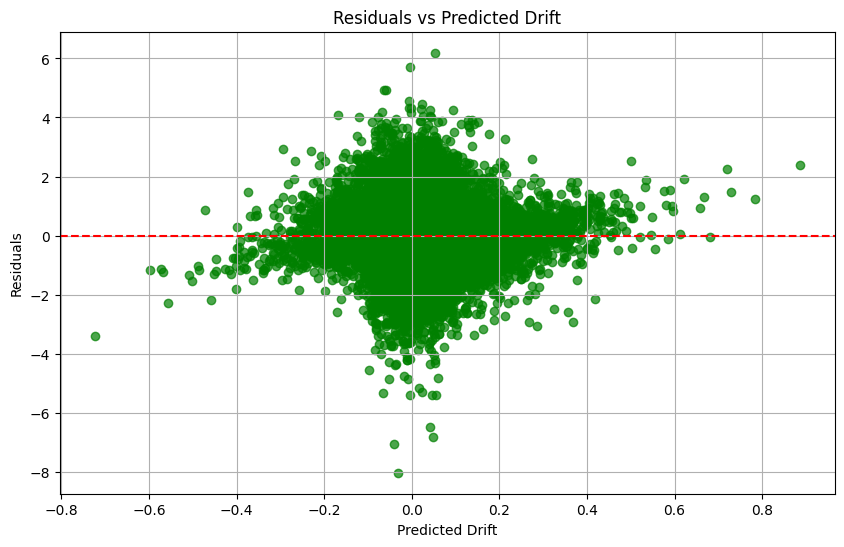

In [40]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Combine data for both stimuli
mean_activity = np.concatenate([mean_activity_r_1, mean_activity_r_2], axis=0)
drift = np.concatenate([drift_r_1, drift_r_2], axis=0)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(mean_activity, drift, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 2: Build the Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(mean_activity.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(mean_activity.shape[1], activation='linear')  # Output layer for drift vector
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 3: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Step 4: Evaluate the Model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Step 5: Analyze Predictions
# Predict on test data
predictions = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
accuracy = np.mean(np.abs(predictions - y_test) <= 0.1 * np.abs(y_test)) * 100  # ±10% tolerance

print(f"Test MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Accuracy: {accuracy:.2f}%")

# Step 6: Plot Predicted vs Actual Drift
plt.figure(figsize=(10, 6))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Prediction (y=x)")
plt.title("Predicted vs Actual Drift")
plt.xlabel("Actual Drift")
plt.ylabel("Predicted Drift")
plt.legend()
plt.grid()
plt.show()

# Step 7: Residual Analysis
residuals = y_test - predictions

plt.figure(figsize=(10, 6))
plt.scatter(predictions.flatten(), residuals.flatten(), alpha=0.7, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Drift")
plt.xlabel("Predicted Drift")
plt.ylabel("Residuals")
plt.grid()
plt.show()


Epoch 1/50
6/6 [==============================] - 1s 33ms/step - loss: 1.7165 - mae: 1.1309 - val_loss: 1.2190 - val_mae: 0.9020
Epoch 2/50
6/6 [==============================] - 0s 17ms/step - loss: 1.0253 - mae: 0.7941 - val_loss: 0.6125 - val_mae: 0.5881
Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 0.5883 - mae: 0.5842 - val_loss: 0.4174 - val_mae: 0.4813
Epoch 4/50
6/6 [==============================] - 0s 17ms/step - loss: 0.4364 - mae: 0.5015 - val_loss: 0.2838 - val_mae: 0.3915
Epoch 5/50
6/6 [==============================] - 0s 17ms/step - loss: 0.3466 - mae: 0.4483 - val_loss: 0.2033 - val_mae: 0.3318
Epoch 6/50
6/6 [==============================] - 0s 17ms/step - loss: 0.3192 - mae: 0.4313 - val_loss: 0.2035 - val_mae: 0.3341
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.2972 - mae: 0.4155 - val_loss: 0.2038 - val_mae: 0.3364
Epoch 8/50
6/6 [==============================] - 0s 16ms/step - loss: 0.2635 - mae: 0.3899 - val

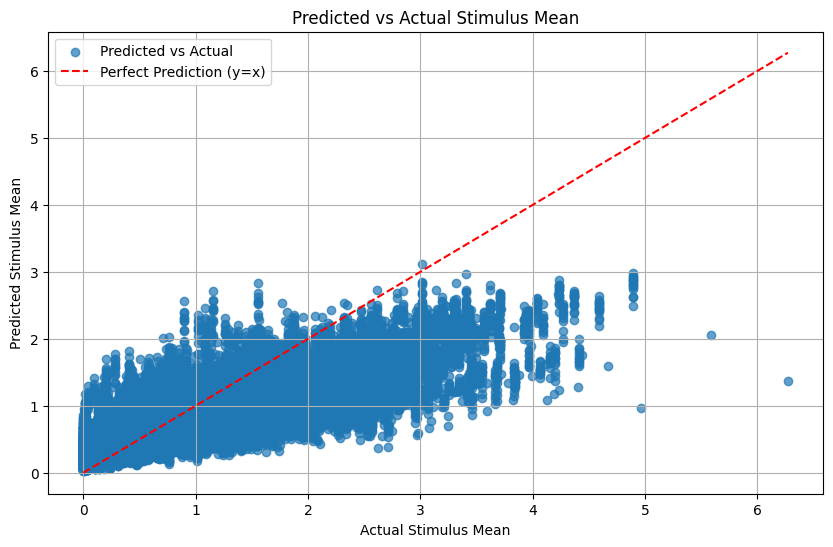

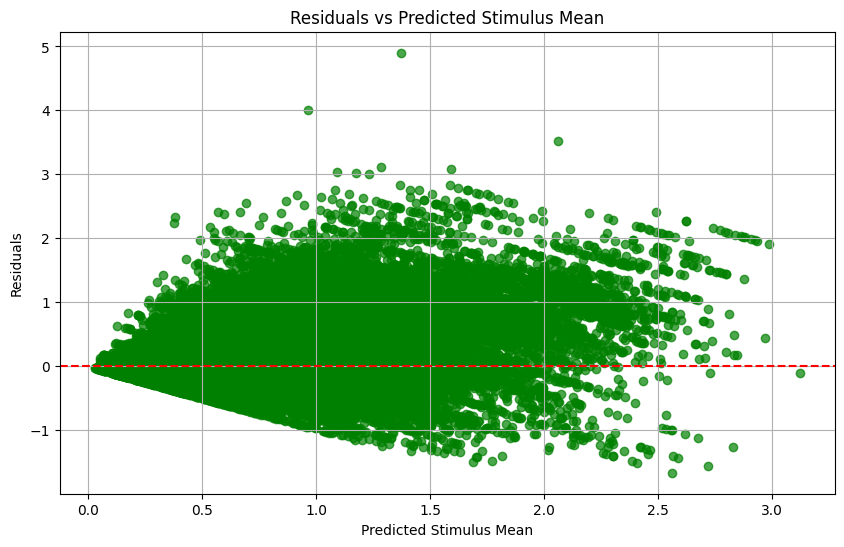

In [43]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Align activity with trial indices
mean_activity_cs_1 = mean_activity_cs_1[trial_r_1]  # Reactivation drift values for stimulus 1
mean_activity_cs_2 = mean_activity_cs_2[trial_r_2]  # Reactivation drift values for stimulus 2

# Combine data for both stimuli
mean_activity = np.concatenate([mean_activity_r_1, mean_activity_r_2], axis=0)
stimulus_mean = np.concatenate([mean_activity_cs_1, mean_activity_cs_2], axis=0)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(mean_activity, stimulus_mean, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 2: Build the Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(mean_activity.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(mean_activity.shape[1], activation='linear')  # Output layer for stimulus mean
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 3: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Step 4: Evaluate the Model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Step 5: Analyze Predictions
# Predict on test data
predictions = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
accuracy = np.mean(np.abs(predictions - y_test) <= 0.1 * np.abs(y_test)) * 100  # ±10% tolerance

print(f"Test MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Accuracy: {accuracy:.2f}%")

# Step 6: Plot Predicted vs Actual Stimulus Mean
plt.figure(figsize=(10, 6))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Prediction (y=x)")
plt.title("Predicted vs Actual Stimulus Mean")
plt.xlabel("Actual Stimulus Mean")
plt.ylabel("Predicted Stimulus Mean")
plt.legend()
plt.grid()
plt.show()

# Step 7: Residual Analysis
residuals = y_test - predictions

plt.figure(figsize=(10, 6))
plt.scatter(predictions.flatten(), residuals.flatten(), alpha=0.7, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Stimulus Mean")
plt.xlabel("Predicted Stimulus Mean")
plt.ylabel("Residuals")
plt.grid()
plt.show()


In [34]:
reactivation_mask_cs_1 = reactivation_cs_1 > p_threshold
reactivation_mask_cs_2 = reactivation_cs_2 > p_threshold
print(activity.shape)

# Extract framewise activity
framewise_activity_1 = activity[:, reactivation_mask_cs_1]  # Frames for stimulus 1
framewise_activity_2 = activity[:, reactivation_mask_cs_2]  # Frames for stimulus 2

print(framewise_activity_1.shape, framewise_activity_2.shape)

(3124, 106665)
(3124, 3774) (3124, 3331)


In [ ]:
# Combine framewise reactivation data and corresponding drift values
framewise_activity = np.concatenate([framewise_activity_1, framewise_activity_2], axis=0)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(framewise_activity, drift, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 2: Build the Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(framewise_activity.shape[1], framewise_activity.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(framewise_activity.shape[2], activation='linear')  # Output layer for drift vector
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 3: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Step 4: Evaluate the Model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Step 5: Analyze Predictions
# Predict on test data
predictions = model.predict(X_test)

# Calculate correlation between predictions and actual drift
correlations = [np.corrcoef(predictions[:, i], y_test[:, i])[0, 1] for i in range(y_test.shape[1])]
print("Average Correlation:", np.mean(correlations))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3774 and the array at index 1 has size 3331